In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
df1 = pd.read_csv('../../_data/Sepulveda_et_al_2020-master/data/value/GlamDataFF2018_Dislike_NoBin.csv', index_col=0)
df2 = pd.read_csv('../../_data/Sepulveda_et_al_2020-master/data/value/GlamDataFF2018_Like_NoBin.csv', index_col=0)
df1['goal'] = -1
df2['goal'] = 1
data_df = pd.concat([df1, df2]).sort_values(by=['subject', 'trial'])
data_df.reset_index(drop=True, inplace=True)

data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['sbj'] = data_df['sbj'].map({data_df['sbj'].unique()[i]:i+1 for i in range(len(data_df['sbj'].unique()))})

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)

data_df['Right Value - Left Value'] = data_df['item_value_1'] - data_df['item_value_0']

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'choice']])
X_train = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

obs_test = np.asarray(data_df[['rt', 'choice']])
X_test = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

print(X_train.shape, X_test.shape)

(7289, 5) (7289, 5)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 10, 8]
input_shape = 5
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 out_layer (Out_layer)       (None, 2)                 111       
                                                                 
Total params: 479 (1.87 KB)
Trainable params: 479 (1.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3000)

Epoch 1/3000
1/1 [==============================] - 208s 208s/step - loss: 60853.8047
Epoch 2/3000
1/1 [==============================] - 0s 361ms/step - loss: 60511.3203
Epoch 3/3000
1/1 [==============================] - 0s 196ms/step - loss: 60284.3203
Epoch 4/3000
1/1 [==============================] - 0s 67ms/step - loss: 60102.4375
Epoch 5/3000
1/1 [==============================] - 0s 45ms/step - loss: 59944.2695
Epoch 6/3000
1/1 [==============================] - 0s 44ms/step - loss: 59799.9414
Epoch 7/3000
1/1 [==============================] - 0s 54ms/step - loss: 59664.0664
Epoch 8/3000
1/1 [==============================] - 0s 57ms/step - loss: 59533.3984
Epoch 9/3000
1/1 [==============================] - 0s 45ms/step - loss: 59405.9062
Epoch 10/3000
1/1 [==============================] - 0s 43ms/step - loss: 59280.2656
Epoch 11/3000
1/1 [==============================] - 0s 45ms/step - loss: 59155.5938
Epoch 12/3000
1/1 [==============================] - 0s 48ms/step - lo

1/1 [==============================] - 0s 65ms/step - loss: 50587.0469
Epoch 98/3000
1/1 [==============================] - 0s 64ms/step - loss: 50530.0234
Epoch 99/3000
1/1 [==============================] - 0s 64ms/step - loss: 50473.6484
Epoch 100/3000
1/1 [==============================] - 0s 64ms/step - loss: 50417.8945
Epoch 101/3000
1/1 [==============================] - 0s 64ms/step - loss: 50362.7578
Epoch 102/3000
1/1 [==============================] - 0s 63ms/step - loss: 50308.2266
Epoch 103/3000
1/1 [==============================] - 0s 63ms/step - loss: 50254.2930
Epoch 104/3000
1/1 [==============================] - 0s 65ms/step - loss: 50200.9336
Epoch 105/3000
1/1 [==============================] - 0s 63ms/step - loss: 50148.1406
Epoch 106/3000
1/1 [==============================] - 0s 62ms/step - loss: 50095.9062
Epoch 107/3000
1/1 [==============================] - 0s 64ms/step - loss: 50044.2188
Epoch 108/3000
1/1 [==============================] - 0s 62ms/step - lo

1/1 [==============================] - 0s 63ms/step - loss: 46896.1367
Epoch 193/3000
1/1 [==============================] - 0s 63ms/step - loss: 46868.3359
Epoch 194/3000
1/1 [==============================] - 0s 66ms/step - loss: 46840.6797
Epoch 195/3000
1/1 [==============================] - 0s 64ms/step - loss: 46813.1445
Epoch 196/3000
1/1 [==============================] - 0s 65ms/step - loss: 46785.7500
Epoch 197/3000
1/1 [==============================] - 0s 66ms/step - loss: 46758.4922
Epoch 198/3000
1/1 [==============================] - 0s 64ms/step - loss: 46731.3555
Epoch 199/3000
1/1 [==============================] - 0s 65ms/step - loss: 46704.3438
Epoch 200/3000
1/1 [==============================] - 0s 64ms/step - loss: 46677.4688
Epoch 201/3000
1/1 [==============================] - 0s 64ms/step - loss: 46650.7109
Epoch 202/3000
1/1 [==============================] - 0s 64ms/step - loss: 46624.0859
Epoch 203/3000
1/1 [==============================] - 0s 63ms/step - 

1/1 [==============================] - 0s 63ms/step - loss: 44692.6484
Epoch 288/3000
1/1 [==============================] - 0s 65ms/step - loss: 44672.8008
Epoch 289/3000
1/1 [==============================] - 0s 63ms/step - loss: 44653.0000
Epoch 290/3000
1/1 [==============================] - 0s 64ms/step - loss: 44633.2422
Epoch 291/3000
1/1 [==============================] - 0s 61ms/step - loss: 44613.5312
Epoch 292/3000
1/1 [==============================] - 0s 63ms/step - loss: 44593.8750
Epoch 293/3000
1/1 [==============================] - 0s 63ms/step - loss: 44574.2656
Epoch 294/3000
1/1 [==============================] - 0s 63ms/step - loss: 44554.6953
Epoch 295/3000
1/1 [==============================] - 0s 63ms/step - loss: 44535.1797
Epoch 296/3000
1/1 [==============================] - 0s 63ms/step - loss: 44515.7109
Epoch 297/3000
1/1 [==============================] - 0s 63ms/step - loss: 44496.2812
Epoch 298/3000
1/1 [==============================] - 0s 63ms/step - 

1/1 [==============================] - 0s 69ms/step - loss: 42979.5586
Epoch 383/3000
1/1 [==============================] - 0s 66ms/step - loss: 42963.0156
Epoch 384/3000
1/1 [==============================] - 0s 67ms/step - loss: 42946.4961
Epoch 385/3000
1/1 [==============================] - 0s 67ms/step - loss: 42929.9961
Epoch 386/3000
1/1 [==============================] - 0s 67ms/step - loss: 42913.5156
Epoch 387/3000
1/1 [==============================] - 0s 66ms/step - loss: 42897.0781
Epoch 388/3000
1/1 [==============================] - 0s 68ms/step - loss: 42880.6484
Epoch 389/3000
1/1 [==============================] - 0s 68ms/step - loss: 42864.2461
Epoch 390/3000
1/1 [==============================] - 0s 67ms/step - loss: 42847.8789
Epoch 391/3000
1/1 [==============================] - 0s 65ms/step - loss: 42831.5273
Epoch 392/3000
1/1 [==============================] - 0s 66ms/step - loss: 42815.1992
Epoch 393/3000
1/1 [==============================] - 0s 68ms/step - 

1/1 [==============================] - 0s 64ms/step - loss: 41507.0547
Epoch 478/3000
1/1 [==============================] - 0s 65ms/step - loss: 41492.5234
Epoch 479/3000
1/1 [==============================] - 0s 63ms/step - loss: 41478.0039
Epoch 480/3000
1/1 [==============================] - 0s 64ms/step - loss: 41463.5156
Epoch 481/3000
1/1 [==============================] - 0s 64ms/step - loss: 41449.0312
Epoch 482/3000
1/1 [==============================] - 0s 63ms/step - loss: 41434.5703
Epoch 483/3000
1/1 [==============================] - 0s 64ms/step - loss: 41420.1289
Epoch 484/3000
1/1 [==============================] - 0s 64ms/step - loss: 41405.7109
Epoch 485/3000
1/1 [==============================] - 0s 64ms/step - loss: 41391.2969
Epoch 486/3000
1/1 [==============================] - 0s 65ms/step - loss: 41376.9102
Epoch 487/3000
1/1 [==============================] - 0s 62ms/step - loss: 41362.5391
Epoch 488/3000
1/1 [==============================] - 0s 63ms/step - 

1/1 [==============================] - 0s 63ms/step - loss: 40190.2930
Epoch 573/3000
1/1 [==============================] - 0s 65ms/step - loss: 40176.9453
Epoch 574/3000
1/1 [==============================] - 0s 63ms/step - loss: 40163.5859
Epoch 575/3000
1/1 [==============================] - 0s 64ms/step - loss: 40150.2539
Epoch 576/3000
1/1 [==============================] - 0s 64ms/step - loss: 40136.9102
Epoch 577/3000
1/1 [==============================] - 0s 65ms/step - loss: 40123.5938
Epoch 578/3000
1/1 [==============================] - 0s 62ms/step - loss: 40110.2656
Epoch 579/3000
1/1 [==============================] - 0s 64ms/step - loss: 40096.9531
Epoch 580/3000
1/1 [==============================] - 0s 63ms/step - loss: 40083.6328
Epoch 581/3000
1/1 [==============================] - 0s 63ms/step - loss: 40070.3359
Epoch 582/3000
1/1 [==============================] - 0s 64ms/step - loss: 40057.0273
Epoch 583/3000
1/1 [==============================] - 0s 63ms/step - 

1/1 [==============================] - 0s 64ms/step - loss: 38739.5156
Epoch 668/3000
1/1 [==============================] - 0s 65ms/step - loss: 38723.7891
Epoch 669/3000
1/1 [==============================] - 0s 63ms/step - loss: 38708.1953
Epoch 670/3000
1/1 [==============================] - 0s 63ms/step - loss: 38692.5508
Epoch 671/3000
1/1 [==============================] - 0s 64ms/step - loss: 38677.0508
Epoch 672/3000
1/1 [==============================] - 0s 64ms/step - loss: 38661.4961
Epoch 673/3000
1/1 [==============================] - 0s 65ms/step - loss: 38646.0859
Epoch 674/3000
1/1 [==============================] - 0s 63ms/step - loss: 38630.6055
Epoch 675/3000
1/1 [==============================] - 0s 64ms/step - loss: 38615.2891
Epoch 676/3000
1/1 [==============================] - 0s 64ms/step - loss: 38599.9023
Epoch 677/3000
1/1 [==============================] - 0s 63ms/step - loss: 38584.6641
Epoch 678/3000
1/1 [==============================] - 0s 64ms/step - 

1/1 [==============================] - 0s 64ms/step - loss: 37438.5352
Epoch 763/3000
1/1 [==============================] - 0s 64ms/step - loss: 37426.5664
Epoch 764/3000
1/1 [==============================] - 0s 64ms/step - loss: 37414.4453
Epoch 765/3000
1/1 [==============================] - 0s 64ms/step - loss: 37402.5273
Epoch 766/3000
1/1 [==============================] - 0s 62ms/step - loss: 37390.4570
Epoch 767/3000
1/1 [==============================] - 0s 64ms/step - loss: 37378.5898
Epoch 768/3000
1/1 [==============================] - 0s 64ms/step - loss: 37366.5703
Epoch 769/3000
1/1 [==============================] - 0s 65ms/step - loss: 37354.7422
Epoch 770/3000
1/1 [==============================] - 0s 64ms/step - loss: 37342.7812
Epoch 771/3000
1/1 [==============================] - 0s 62ms/step - loss: 37331.0000
Epoch 772/3000
1/1 [==============================] - 0s 62ms/step - loss: 37319.0820
Epoch 773/3000
1/1 [==============================] - 0s 64ms/step - 

1/1 [==============================] - 0s 68ms/step - loss: 36362.9141
Epoch 858/3000
1/1 [==============================] - 0s 68ms/step - loss: 36351.8320
Epoch 859/3000
1/1 [==============================] - 0s 66ms/step - loss: 36340.8828
Epoch 860/3000
1/1 [==============================] - 0s 67ms/step - loss: 36329.8047
Epoch 861/3000
1/1 [==============================] - 0s 73ms/step - loss: 36318.8516
Epoch 862/3000
1/1 [==============================] - 0s 67ms/step - loss: 36307.7734
Epoch 863/3000
1/1 [==============================] - 0s 69ms/step - loss: 36296.8203
Epoch 864/3000
1/1 [==============================] - 0s 68ms/step - loss: 36285.7461
Epoch 865/3000
1/1 [==============================] - 0s 67ms/step - loss: 36274.7969
Epoch 866/3000
1/1 [==============================] - 0s 64ms/step - loss: 36263.7188
Epoch 867/3000
1/1 [==============================] - 0s 63ms/step - loss: 36252.7734
Epoch 868/3000
1/1 [==============================] - 0s 70ms/step - 

1/1 [==============================] - 0s 64ms/step - loss: 35293.6094
Epoch 953/3000
1/1 [==============================] - 0s 63ms/step - loss: 35281.7305
Epoch 954/3000
1/1 [==============================] - 0s 64ms/step - loss: 35269.7305
Epoch 955/3000
1/1 [==============================] - 0s 63ms/step - loss: 35257.7773
Epoch 956/3000
1/1 [==============================] - 0s 62ms/step - loss: 35245.7109
Epoch 957/3000
1/1 [==============================] - 0s 64ms/step - loss: 35233.6875
Epoch 958/3000
1/1 [==============================] - 0s 65ms/step - loss: 35221.5469
Epoch 959/3000
1/1 [==============================] - 0s 64ms/step - loss: 35209.4375
Epoch 960/3000
1/1 [==============================] - 0s 64ms/step - loss: 35197.2070
Epoch 961/3000
1/1 [==============================] - 0s 65ms/step - loss: 35185.0117
Epoch 962/3000
1/1 [==============================] - 0s 64ms/step - loss: 35172.6875
Epoch 963/3000
1/1 [==============================] - 0s 63ms/step - 

1/1 [==============================] - 0s 64ms/step - loss: 33768.0508
Epoch 1047/3000
1/1 [==============================] - 0s 64ms/step - loss: 33754.6094
Epoch 1048/3000
1/1 [==============================] - 0s 63ms/step - loss: 33741.1875
Epoch 1049/3000
1/1 [==============================] - 0s 64ms/step - loss: 33727.8516
Epoch 1050/3000
1/1 [==============================] - 0s 63ms/step - loss: 33714.5469
Epoch 1051/3000
1/1 [==============================] - 0s 63ms/step - loss: 33701.3203
Epoch 1052/3000
1/1 [==============================] - 0s 63ms/step - loss: 33688.1172
Epoch 1053/3000
1/1 [==============================] - 0s 64ms/step - loss: 33674.9922
Epoch 1054/3000
1/1 [==============================] - 0s 62ms/step - loss: 33661.8828
Epoch 1055/3000
1/1 [==============================] - 0s 65ms/step - loss: 33648.8594
Epoch 1056/3000
1/1 [==============================] - 0s 64ms/step - loss: 33635.8359
Epoch 1057/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 64ms/step - loss: 32584.7812
Epoch 1141/3000
1/1 [==============================] - 0s 64ms/step - loss: 32571.9062
Epoch 1142/3000
1/1 [==============================] - 0s 63ms/step - loss: 32559.0488
Epoch 1143/3000
1/1 [==============================] - 0s 65ms/step - loss: 32546.1016
Epoch 1144/3000
1/1 [==============================] - 0s 63ms/step - loss: 32533.1719
Epoch 1145/3000
1/1 [==============================] - 0s 64ms/step - loss: 32520.1367
Epoch 1146/3000
1/1 [==============================] - 0s 63ms/step - loss: 32507.1270
Epoch 1147/3000
1/1 [==============================] - 0s 64ms/step - loss: 32494.0039
Epoch 1148/3000
1/1 [==============================] - 0s 62ms/step - loss: 32480.9102
Epoch 1149/3000
1/1 [==============================] - 0s 65ms/step - loss: 32467.7031
Epoch 1150/3000
1/1 [==============================] - 0s 64ms/step - loss: 32454.5312
Epoch 1151/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 64ms/step - loss: 31434.2129
Epoch 1235/3000
1/1 [==============================] - 0s 68ms/step - loss: 31423.5059
Epoch 1236/3000
1/1 [==============================] - 0s 64ms/step - loss: 31413.0859
Epoch 1237/3000
1/1 [==============================] - 0s 62ms/step - loss: 31402.4082
Epoch 1238/3000
1/1 [==============================] - 0s 64ms/step - loss: 31392.0137
Epoch 1239/3000
1/1 [==============================] - 0s 63ms/step - loss: 31381.3555
Epoch 1240/3000
1/1 [==============================] - 0s 65ms/step - loss: 31370.9883
Epoch 1241/3000
1/1 [==============================] - 0s 63ms/step - loss: 31360.3438
Epoch 1242/3000
1/1 [==============================] - 0s 64ms/step - loss: 31350.0000
Epoch 1243/3000
1/1 [==============================] - 0s 64ms/step - loss: 31339.3789
Epoch 1244/3000
1/1 [==============================] - 0s 64ms/step - loss: 31329.0449
Epoch 1245/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 70ms/step - loss: 30479.4531
Epoch 1329/3000
1/1 [==============================] - 0s 70ms/step - loss: 30469.5586
Epoch 1330/3000
1/1 [==============================] - 0s 69ms/step - loss: 30459.9961
Epoch 1331/3000
1/1 [==============================] - 0s 67ms/step - loss: 30450.1641
Epoch 1332/3000
1/1 [==============================] - 0s 66ms/step - loss: 30440.6367
Epoch 1333/3000
1/1 [==============================] - 0s 67ms/step - loss: 30430.8242
Epoch 1334/3000
1/1 [==============================] - 0s 69ms/step - loss: 30421.2871
Epoch 1335/3000
1/1 [==============================] - 0s 69ms/step - loss: 30411.4648
Epoch 1336/3000
1/1 [==============================] - 0s 69ms/step - loss: 30401.9258
Epoch 1337/3000
1/1 [==============================] - 0s 67ms/step - loss: 30392.1172
Epoch 1338/3000
1/1 [==============================] - 0s 67ms/step - loss: 30382.6152
Epoch 1339/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 64ms/step - loss: 29639.8418
Epoch 1423/3000
1/1 [==============================] - 0s 69ms/step - loss: 29632.0938
Epoch 1424/3000
1/1 [==============================] - 0s 64ms/step - loss: 29624.5742
Epoch 1425/3000
1/1 [==============================] - 0s 63ms/step - loss: 29616.8047
Epoch 1426/3000
1/1 [==============================] - 0s 64ms/step - loss: 29609.2617
Epoch 1427/3000
1/1 [==============================] - 0s 65ms/step - loss: 29601.5273
Epoch 1428/3000
1/1 [==============================] - 0s 64ms/step - loss: 29594.0918
Epoch 1429/3000
1/1 [==============================] - 0s 63ms/step - loss: 29586.5156
Epoch 1430/3000
1/1 [==============================] - 0s 65ms/step - loss: 29579.2578
Epoch 1431/3000
1/1 [==============================] - 0s 62ms/step - loss: 29571.8594
Epoch 1432/3000
1/1 [==============================] - 0s 64ms/step - loss: 29564.7402
Epoch 1433/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 63ms/step - loss: 29081.7383
Epoch 1517/3000
1/1 [==============================] - 0s 66ms/step - loss: 29076.8047
Epoch 1518/3000
1/1 [==============================] - 0s 63ms/step - loss: 29072.2227
Epoch 1519/3000
1/1 [==============================] - 0s 63ms/step - loss: 29067.6836
Epoch 1520/3000
1/1 [==============================] - 0s 62ms/step - loss: 29063.5430
Epoch 1521/3000
1/1 [==============================] - 0s 62ms/step - loss: 29059.3555
Epoch 1522/3000
1/1 [==============================] - 0s 64ms/step - loss: 29055.3633
Epoch 1523/3000
1/1 [==============================] - 0s 64ms/step - loss: 29050.8750
Epoch 1524/3000
1/1 [==============================] - 0s 63ms/step - loss: 29046.3906
Epoch 1525/3000
1/1 [==============================] - 0s 62ms/step - loss: 29041.5137
Epoch 1526/3000
1/1 [==============================] - 0s 62ms/step - loss: 29036.9297
Epoch 1527/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 68ms/step - loss: 28719.0742
Epoch 1611/3000
1/1 [==============================] - 0s 65ms/step - loss: 28716.1406
Epoch 1612/3000
1/1 [==============================] - 0s 64ms/step - loss: 28713.4922
Epoch 1613/3000
1/1 [==============================] - 0s 63ms/step - loss: 28710.3477
Epoch 1614/3000
1/1 [==============================] - 0s 64ms/step - loss: 28707.0098
Epoch 1615/3000
1/1 [==============================] - 0s 64ms/step - loss: 28703.0801
Epoch 1616/3000
1/1 [==============================] - 0s 63ms/step - loss: 28699.3633
Epoch 1617/3000
1/1 [==============================] - 0s 62ms/step - loss: 28695.6133
Epoch 1618/3000
1/1 [==============================] - 0s 63ms/step - loss: 28692.3164
Epoch 1619/3000
1/1 [==============================] - 0s 65ms/step - loss: 28689.1797
Epoch 1620/3000
1/1 [==============================] - 0s 65ms/step - loss: 28686.4961
Epoch 1621/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 65ms/step - loss: 28437.8535
Epoch 1705/3000
1/1 [==============================] - 0s 64ms/step - loss: 28434.8828
Epoch 1706/3000
1/1 [==============================] - 0s 65ms/step - loss: 28431.6953
Epoch 1707/3000
1/1 [==============================] - 0s 65ms/step - loss: 28428.0742
Epoch 1708/3000
1/1 [==============================] - 0s 65ms/step - loss: 28424.8516
Epoch 1709/3000
1/1 [==============================] - 0s 65ms/step - loss: 28421.7832
Epoch 1710/3000
1/1 [==============================] - 0s 62ms/step - loss: 28419.2227
Epoch 1711/3000
1/1 [==============================] - 0s 64ms/step - loss: 28416.9570
Epoch 1712/3000
1/1 [==============================] - 0s 65ms/step - loss: 28415.1797
Epoch 1713/3000
1/1 [==============================] - 0s 63ms/step - loss: 28413.2969
Epoch 1714/3000
1/1 [==============================] - 0s 66ms/step - loss: 28410.9844
Epoch 1715/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 66ms/step - loss: 28200.6035
Epoch 1799/3000
1/1 [==============================] - 0s 63ms/step - loss: 28197.6895
Epoch 1800/3000
1/1 [==============================] - 0s 64ms/step - loss: 28194.4707
Epoch 1801/3000
1/1 [==============================] - 0s 67ms/step - loss: 28190.9941
Epoch 1802/3000
1/1 [==============================] - 0s 68ms/step - loss: 28188.1055
Epoch 1803/3000
1/1 [==============================] - 0s 71ms/step - loss: 28185.5352
Epoch 1804/3000
1/1 [==============================] - 0s 68ms/step - loss: 28183.5605
Epoch 1805/3000
1/1 [==============================] - 0s 66ms/step - loss: 28182.0586
Epoch 1806/3000
1/1 [==============================] - 0s 68ms/step - loss: 28181.1211
Epoch 1807/3000
1/1 [==============================] - 0s 67ms/step - loss: 28180.0586
Epoch 1808/3000
1/1 [==============================] - 0s 66ms/step - loss: 28178.2852
Epoch 1809/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 66ms/step - loss: 28008.2188
Epoch 1893/3000
1/1 [==============================] - 0s 64ms/step - loss: 28007.4648
Epoch 1894/3000
1/1 [==============================] - 0s 64ms/step - loss: 28005.7383
Epoch 1895/3000
1/1 [==============================] - 0s 64ms/step - loss: 28002.5996
Epoch 1896/3000
1/1 [==============================] - 0s 62ms/step - loss: 27999.4434
Epoch 1897/3000
1/1 [==============================] - 0s 64ms/step - loss: 27996.4766
Epoch 1898/3000
1/1 [==============================] - 0s 64ms/step - loss: 27994.1406
Epoch 1899/3000
1/1 [==============================] - 0s 64ms/step - loss: 27992.3203
Epoch 1900/3000
1/1 [==============================] - 0s 65ms/step - loss: 27991.2012
Epoch 1901/3000
1/1 [==============================] - 0s 64ms/step - loss: 27990.6445
Epoch 1902/3000
1/1 [==============================] - 0s 65ms/step - loss: 27990.4570
Epoch 1903/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 102ms/step - loss: 27845.5293
Epoch 1987/3000
1/1 [==============================] - 0s 87ms/step - loss: 27845.5234
Epoch 1988/3000
1/1 [==============================] - 0s 70ms/step - loss: 27845.7656
Epoch 1989/3000
1/1 [==============================] - 0s 66ms/step - loss: 27844.8008
Epoch 1990/3000
1/1 [==============================] - 0s 66ms/step - loss: 27842.4648
Epoch 1991/3000
1/1 [==============================] - 0s 64ms/step - loss: 27839.2129
Epoch 1992/3000
1/1 [==============================] - 0s 64ms/step - loss: 27836.2051
Epoch 1993/3000
1/1 [==============================] - 0s 65ms/step - loss: 27833.7656
Epoch 1994/3000
1/1 [==============================] - 0s 65ms/step - loss: 27831.9609
Epoch 1995/3000
1/1 [==============================] - 0s 64ms/step - loss: 27830.7812
Epoch 1996/3000
1/1 [==============================] - 0s 65ms/step - loss: 27830.3906
Epoch 1997/3000
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 63ms/step - loss: 27705.8516
Epoch 2081/3000
1/1 [==============================] - 0s 64ms/step - loss: 27705.0918
Epoch 2082/3000
1/1 [==============================] - 0s 63ms/step - loss: 27705.3047
Epoch 2083/3000
1/1 [==============================] - 0s 63ms/step - loss: 27705.9863
Epoch 2084/3000
1/1 [==============================] - 0s 63ms/step - loss: 27706.1406
Epoch 2085/3000
1/1 [==============================] - 0s 63ms/step - loss: 27704.2734
Epoch 2086/3000
1/1 [==============================] - 0s 64ms/step - loss: 27701.2383
Epoch 2087/3000
1/1 [==============================] - 0s 65ms/step - loss: 27698.0039
Epoch 2088/3000
1/1 [==============================] - 0s 63ms/step - loss: 27695.4043
Epoch 2089/3000
1/1 [==============================] - 0s 63ms/step - loss: 27693.5449
Epoch 2090/3000
1/1 [==============================] - 0s 64ms/step - loss: 27692.4023
Epoch 2091/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 65ms/step - loss: 27585.4688
Epoch 2175/3000
1/1 [==============================] - 0s 64ms/step - loss: 27583.9883
Epoch 2176/3000
1/1 [==============================] - 0s 65ms/step - loss: 27583.3125
Epoch 2177/3000
1/1 [==============================] - 0s 65ms/step - loss: 27583.6309
Epoch 2178/3000
1/1 [==============================] - 0s 64ms/step - loss: 27584.7930
Epoch 2179/3000
1/1 [==============================] - 0s 63ms/step - loss: 27585.4199
Epoch 2180/3000
1/1 [==============================] - 0s 65ms/step - loss: 27584.2227
Epoch 2181/3000
1/1 [==============================] - 0s 64ms/step - loss: 27581.1758
Epoch 2182/3000
1/1 [==============================] - 0s 64ms/step - loss: 27577.8574
Epoch 2183/3000
1/1 [==============================] - 0s 64ms/step - loss: 27575.1836
Epoch 2184/3000
1/1 [==============================] - 0s 63ms/step - loss: 27573.3477
Epoch 2185/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 64ms/step - loss: 27482.8672
Epoch 2269/3000
1/1 [==============================] - 0s 66ms/step - loss: 27480.5957
Epoch 2270/3000
1/1 [==============================] - 0s 63ms/step - loss: 27479.3750
Epoch 2271/3000
1/1 [==============================] - 0s 63ms/step - loss: 27478.9531
Epoch 2272/3000
1/1 [==============================] - 0s 62ms/step - loss: 27479.6680
Epoch 2273/3000
1/1 [==============================] - 0s 63ms/step - loss: 27481.5332
Epoch 2274/3000
1/1 [==============================] - 0s 65ms/step - loss: 27482.9531
Epoch 2275/3000
1/1 [==============================] - 0s 66ms/step - loss: 27481.7617
Epoch 2276/3000
1/1 [==============================] - 0s 71ms/step - loss: 27478.4180
Epoch 2277/3000
1/1 [==============================] - 0s 69ms/step - loss: 27474.8301
Epoch 2278/3000
1/1 [==============================] - 0s 67ms/step - loss: 27472.1641
Epoch 2279/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 64ms/step - loss: 27396.5000
Epoch 2363/3000
1/1 [==============================] - 0s 64ms/step - loss: 27393.9062
Epoch 2364/3000
1/1 [==============================] - 0s 63ms/step - loss: 27392.1035
Epoch 2365/3000
1/1 [==============================] - 0s 63ms/step - loss: 27391.3477
Epoch 2366/3000
1/1 [==============================] - 0s 64ms/step - loss: 27391.7988
Epoch 2367/3000
1/1 [==============================] - 0s 64ms/step - loss: 27393.3184
Epoch 2368/3000
1/1 [==============================] - 0s 64ms/step - loss: 27395.6914
Epoch 2369/3000
1/1 [==============================] - 0s 63ms/step - loss: 27396.3945
Epoch 2370/3000
1/1 [==============================] - 0s 64ms/step - loss: 27394.0449
Epoch 2371/3000
1/1 [==============================] - 0s 66ms/step - loss: 27390.3750
Epoch 2372/3000
1/1 [==============================] - 0s 64ms/step - loss: 27386.9727
Epoch 2373/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 66ms/step - loss: 27323.2363
Epoch 2457/3000
1/1 [==============================] - 0s 66ms/step - loss: 27320.2754
Epoch 2458/3000
1/1 [==============================] - 0s 63ms/step - loss: 27318.5176
Epoch 2459/3000
1/1 [==============================] - 0s 67ms/step - loss: 27316.9980
Epoch 2460/3000
1/1 [==============================] - 0s 68ms/step - loss: 27316.9980
Epoch 2461/3000
1/1 [==============================] - 0s 68ms/step - loss: 27318.3125
Epoch 2462/3000
1/1 [==============================] - 0s 66ms/step - loss: 27321.0254
Epoch 2463/3000
1/1 [==============================] - 0s 65ms/step - loss: 27323.9102
Epoch 2464/3000
1/1 [==============================] - 0s 64ms/step - loss: 27323.2910
Epoch 2465/3000
1/1 [==============================] - 0s 63ms/step - loss: 27319.3477
Epoch 2466/3000
1/1 [==============================] - 0s 64ms/step - loss: 27315.2480
Epoch 2467/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 65ms/step - loss: 27260.9004
Epoch 2551/3000
1/1 [==============================] - 0s 70ms/step - loss: 27257.7793
Epoch 2552/3000
1/1 [==============================] - 0s 64ms/step - loss: 27255.4316
Epoch 2553/3000
1/1 [==============================] - 0s 64ms/step - loss: 27254.0723
Epoch 2554/3000
1/1 [==============================] - 0s 64ms/step - loss: 27253.7305
Epoch 2555/3000
1/1 [==============================] - 0s 65ms/step - loss: 27255.4375
Epoch 2556/3000
1/1 [==============================] - 0s 64ms/step - loss: 27258.2578
Epoch 2557/3000
1/1 [==============================] - 0s 64ms/step - loss: 27261.1758
Epoch 2558/3000
1/1 [==============================] - 0s 63ms/step - loss: 27260.3477
Epoch 2559/3000
1/1 [==============================] - 0s 62ms/step - loss: 27256.1367
Epoch 2560/3000
1/1 [==============================] - 0s 63ms/step - loss: 27252.1426
Epoch 2561/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 64ms/step - loss: 27205.3613
Epoch 2645/3000
1/1 [==============================] - 0s 64ms/step - loss: 27201.6309
Epoch 2646/3000
1/1 [==============================] - 0s 63ms/step - loss: 27198.9492
Epoch 2647/3000
1/1 [==============================] - 0s 65ms/step - loss: 27197.2734
Epoch 2648/3000
1/1 [==============================] - 0s 64ms/step - loss: 27197.0234
Epoch 2649/3000
1/1 [==============================] - 0s 62ms/step - loss: 27198.6016
Epoch 2650/3000
1/1 [==============================] - 0s 63ms/step - loss: 27201.6445
Epoch 2651/3000
1/1 [==============================] - 0s 65ms/step - loss: 27206.2070
Epoch 2652/3000
1/1 [==============================] - 0s 65ms/step - loss: 27207.0449
Epoch 2653/3000
1/1 [==============================] - 0s 63ms/step - loss: 27203.8906
Epoch 2654/3000
1/1 [==============================] - 0s 64ms/step - loss: 27198.6855
Epoch 2655/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 64ms/step - loss: 27156.8223
Epoch 2739/3000
1/1 [==============================] - 0s 64ms/step - loss: 27153.9531
Epoch 2740/3000
1/1 [==============================] - 0s 63ms/step - loss: 27151.4219
Epoch 2741/3000
1/1 [==============================] - 0s 65ms/step - loss: 27149.4941
Epoch 2742/3000
1/1 [==============================] - 0s 64ms/step - loss: 27148.8887
Epoch 2743/3000
1/1 [==============================] - 0s 64ms/step - loss: 27150.3203
Epoch 2744/3000
1/1 [==============================] - 0s 64ms/step - loss: 27153.8145
Epoch 2745/3000
1/1 [==============================] - 0s 64ms/step - loss: 27157.7207
Epoch 2746/3000
1/1 [==============================] - 0s 62ms/step - loss: 27159.2852
Epoch 2747/3000
1/1 [==============================] - 0s 64ms/step - loss: 27157.2773
Epoch 2748/3000
1/1 [==============================] - 0s 64ms/step - loss: 27151.9688
Epoch 2749/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 66ms/step - loss: 27118.1992
Epoch 2833/3000
1/1 [==============================] - 0s 67ms/step - loss: 27117.7188
Epoch 2834/3000
1/1 [==============================] - 0s 64ms/step - loss: 27113.6465
Epoch 2835/3000
1/1 [==============================] - 0s 65ms/step - loss: 27110.0586
Epoch 2836/3000
1/1 [==============================] - 0s 64ms/step - loss: 27108.2422
Epoch 2837/3000
1/1 [==============================] - 0s 65ms/step - loss: 27106.1328
Epoch 2838/3000
1/1 [==============================] - 0s 66ms/step - loss: 27104.7852
Epoch 2839/3000
1/1 [==============================] - 0s 65ms/step - loss: 27105.0742
Epoch 2840/3000
1/1 [==============================] - 0s 65ms/step - loss: 27105.5273
Epoch 2841/3000
1/1 [==============================] - 0s 64ms/step - loss: 27108.6035
Epoch 2842/3000
1/1 [==============================] - 0s 65ms/step - loss: 27114.6875
Epoch 2843/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 66ms/step - loss: 27072.9531
Epoch 2927/3000
1/1 [==============================] - 0s 69ms/step - loss: 27074.6855
Epoch 2928/3000
1/1 [==============================] - 0s 68ms/step - loss: 27075.6602
Epoch 2929/3000
1/1 [==============================] - 0s 68ms/step - loss: 27078.4395
Epoch 2930/3000
1/1 [==============================] - 0s 69ms/step - loss: 27089.2363
Epoch 2931/3000
1/1 [==============================] - 0s 68ms/step - loss: 27107.2852
Epoch 2932/3000
1/1 [==============================] - 0s 66ms/step - loss: 27099.0664
Epoch 2933/3000
1/1 [==============================] - 0s 64ms/step - loss: 27078.0469
Epoch 2934/3000
1/1 [==============================] - 0s 66ms/step - loss: 27067.6562
Epoch 2935/3000
1/1 [==============================] - 0s 66ms/step - loss: 27064.2500
Epoch 2936/3000
1/1 [==============================] - 0s 69ms/step - loss: 27062.0605
Epoch 2937/3000
1/1 [==============================] - 0s 6

In [9]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

228/228 [==============================] - 0s 295us/step


In [10]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'goal':[],
            'val1': [],
            'val2':[],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['goal'].append(ts_df.goal[s])
        pred_bhv['val1'].append(ts_df.item_value_0[s])
        pred_bhv['val2'].append(ts_df.item_value_1[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)
pred_bhv['diff'] = pred_bhv['val2'] - pred_bhv['val1']

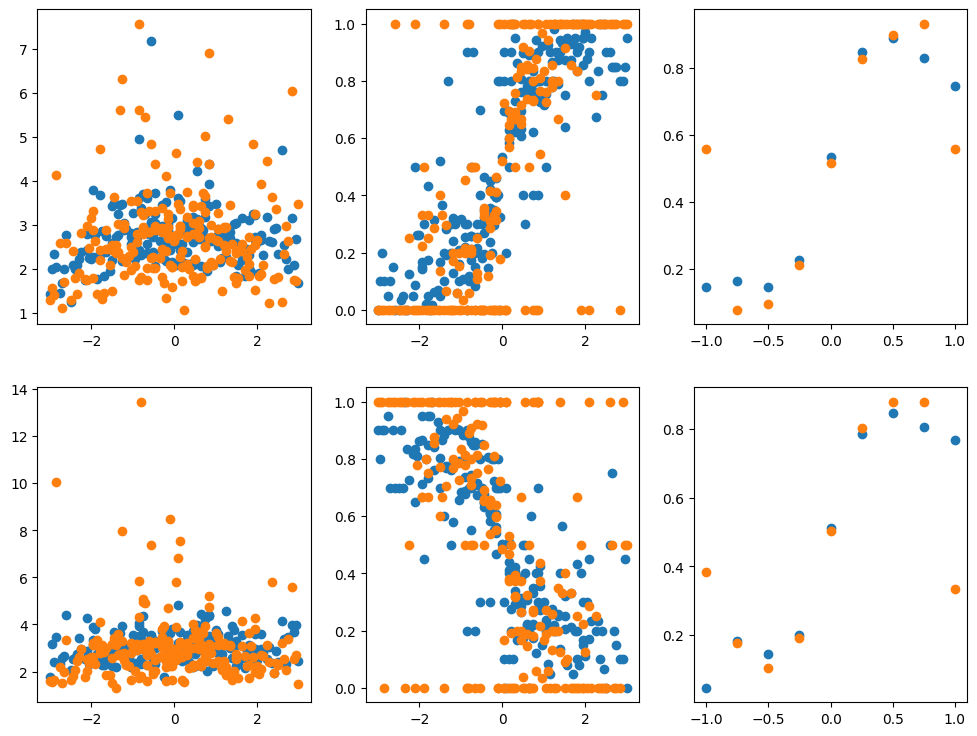

In [11]:
plt.figure(figsize=(12, 9))
plt.subplot(231)
plt.scatter(x=pred_bhv[pred_bhv['goal']==1].groupby(by='diff')['diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==1].groupby(by='diff')['rt'].mean());
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['rt'].mean());

plt.subplot(232)
plt.scatter(x=pred_bhv[pred_bhv['goal']==1].groupby(by='diff')['diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==1].groupby(by='diff')['ch'].mean());
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['choice'].mean());

plt.subplot(233)
plt.scatter(x=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].mean());
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean());

###########
plt.subplot(234)
plt.scatter(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='diff')['diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==-1].groupby(by='diff')['rt'].mean());
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['rt'].mean());

plt.subplot(235)
plt.scatter(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='diff')['diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==-1].groupby(by='diff')['ch'].mean());
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['choice'].mean());

plt.subplot(236)
plt.scatter(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].mean());
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean());

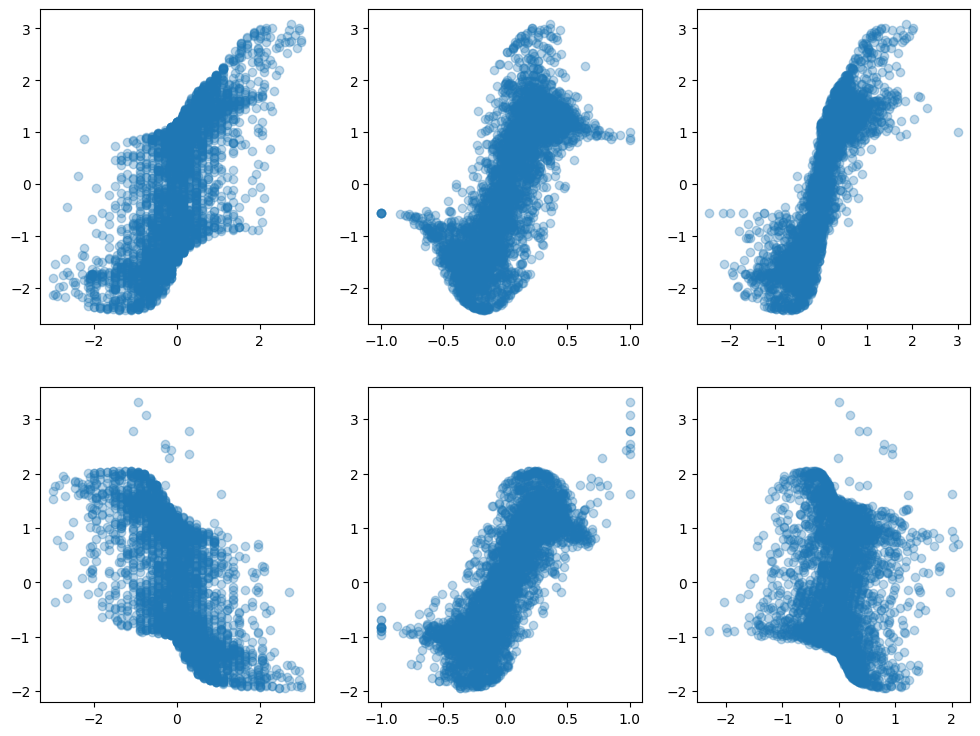

In [12]:
plt.figure(figsize=(12, 9))
plt.subplot(231)
plt.scatter(X_test[X_test[:, -1]==1, 0] - X_test[X_test[:, -1]==1, 1], 
            pred_v[X_test[:, -1]==1, 0] - pred_v[X_test[:, -1]==1, 1], alpha=0.3);

plt.subplot(232)
plt.scatter(X_test[X_test[:, -1]==1, 2] - X_test[X_test[:, -1]==1, 3], 
            pred_v[X_test[:, -1]==1, 0] - pred_v[X_test[:, -1]==1, 1], alpha=0.3);

plt.subplot(233)
plt.scatter(X_test[X_test[:, -1]==1, 0]*X_test[X_test[:, -1]==1, 2] - X_test[X_test[:, -1]==1, 1]*X_test[X_test[:, -1]==1, 3], 
            pred_v[X_test[:, -1]==1, 0] - pred_v[X_test[:, -1]==1, 1], alpha=0.3);

#####################
plt.subplot(234)
plt.scatter(X_test[X_test[:, -1]==-1, 0] - X_test[X_test[:, -1]==-1, 1], 
            pred_v[X_test[:, -1]==-1, 0] - pred_v[X_test[:, -1]==-1, 1], alpha=0.3);

plt.subplot(235)
plt.scatter(X_test[X_test[:, -1]==-1, 2] - X_test[X_test[:, -1]==-1, 3], 
            pred_v[X_test[:, -1]==-1, 0] - pred_v[X_test[:, -1]==-1, 1], alpha=0.3);

plt.subplot(236)
plt.scatter(X_test[X_test[:, -1]==-1, 0]*X_test[X_test[:, -1]==-1, 2] - X_test[X_test[:, -1]==-1, 1]*X_test[X_test[:, -1]==-1, 3], 
            pred_v[X_test[:, -1]==-1, 0] - pred_v[X_test[:, -1]==-1, 1], alpha=0.3);